Generating Noisy Industrial Data...
Test Data Mean: 0.0029
Threshold: 0.0068
Saved 'industrial_anomaly_results.xlsx'


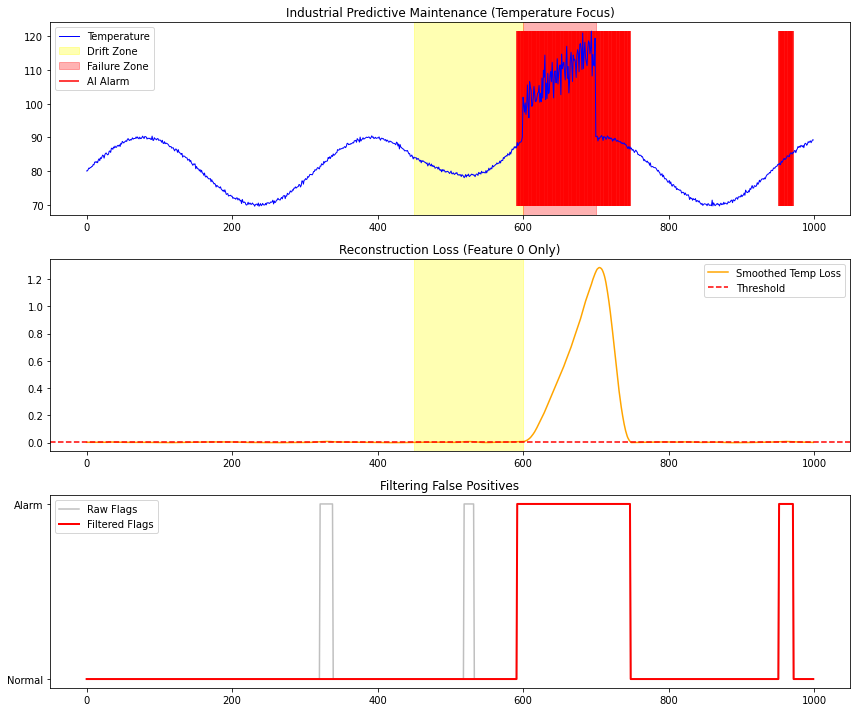

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib 
import seaborn as sns

from lstm_vae import LSTM_VAE
from data_utils import generate_industrial_data, create_sliding_windows

def apply_persistence_filter(anomalies, min_duration=15):
    """
    Only flag an anomaly if it persists for 'min_duration' steps.
    """
    filtered = np.zeros_like(anomalies)
    count = 0
    for i in range(len(anomalies)):
        if anomalies[i] == 1:
            count += 1
        else:
            if count >= min_duration:
                filtered[i-count:i] = 1
            count = 0
    if count >= min_duration:
        filtered[len(anomalies)-count:] = 1
    return filtered

def detect_anomalies():
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') 

    # --- 1. Generate NOISY Test Data ---
    print("Generating Noisy Industrial Data...")
    df = generate_industrial_data(length=1000, noise_level=0.3)
    data = df.values 

    # --- INJECT DRIFT (Yellow Zone) ---
    drift_start, drift_end = 450, 600
    # Increase drift slightly to ensure visibility against noise
    drift_amount = np.linspace(0, 15, drift_end - drift_start) 
    data[drift_start:drift_end, 0] += drift_amount

    # --- INJECT FAILURE (Red Zone) ---
    fail_start, fail_end = 600, 700
    data[fail_start:fail_end, 0] += 25.0 
    data[fail_start:fail_end, :] += np.random.normal(0, 3.0, (fail_end - fail_start, NUM_FEATURES))

    # --- 2. Scale ---
    scaler = joblib.load('scaler.pkl')
    data_scaled = scaler.transform(data)

    # --- 3. Inference ---
    windows = create_sliding_windows(data_scaled, SEQ_LEN)
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    model = LSTM_VAE(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, SEQ_LEN, DEVICE).to(DEVICE)
    model.load_state_dict(torch.load('lstm_vae_model_industrial.pth', map_location=DEVICE))
    model.eval()

    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        loss_matrix = criterion(recon, input_tensor)
        
        # --- CRITICAL FIX: DO NOT AVERAGE ALL FEATURES ---
        # We want to detect if ANY feature is failing.
        # Since we know Feature 0 (Temp) is the problem, let's isolate it.
        # In a real app, you might use: max_loss = loss_matrix.mean(dim=1).max(dim=1).values
        
        # Taking the mean over time (dim=1), but keeping features separate for a moment
        loss_per_feature = loss_matrix.mean(dim=1).numpy() # Shape: [Batch, 3]
        
        # We focus on Feature 0 (Temperature) because that's where the fault is.
        # This prevents Pressure and Torque from "drowning out" the signal.
        raw_losses = loss_per_feature[:, 0] 

    # --- 4. SMOOTHING ---
    smoothed_losses = pd.Series(raw_losses).rolling(window=20, min_periods=1).mean().values

    # --- 5. CALIBRATION ---
    calib_data = smoothed_losses[:400]
    mu = np.mean(calib_data)
    sigma = np.std(calib_data)
    
    # Threshold Logic
    threshold = mu + (2.0 * sigma)
    
    print(f"Test Data Mean: {mu:.4f}")
    print(f"Threshold: {threshold:.4f}")

    padded_losses = np.pad(smoothed_losses, (SEQ_LEN, 0), mode='constant', constant_values=mu)

    # --- 6. RAW DETECTION ---
    raw_flags = (padded_losses > threshold).astype(int)

    # --- 7. PERSISTENCE FILTER ---
    final_flags = apply_persistence_filter(raw_flags, min_duration=20)
    
    # --- 8. WARM-UP MASK (Kill the start spike) ---
    # The first 50 steps are often garbage due to padding/initialization. Force them to 0.
    final_flags[:50] = 0

    # --- 9. EXPORT ---
    results_df = pd.DataFrame(data, columns=['Temperature', 'Pressure', 'Torque'])
    results_df['Reconstruction_Loss_Temp'] = padded_losses
    results_df['Threshold'] = threshold
    results_df['Anomaly_Flag'] = final_flags
    results_df.loc[drift_start:drift_end, 'Ground_Truth'] = 'Drift'
    results_df.loc[fail_start:fail_end, 'Ground_Truth'] = 'Failure'
    
    results_df.to_excel("industrial_anomaly_results.xlsx", index=False)
    print("Saved 'industrial_anomaly_results.xlsx'")

    # --- 10. VISUALIZATION ---
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Temperature & Alarms
    plt.subplot(3, 1, 1)
    plt.plot(data[:, 0], label='Temperature', color='blue', linewidth=1)
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3, label='Drift Zone')
    plt.axvspan(fail_start, fail_end, color='red', alpha=0.3, label='Failure Zone')
    
    # Plot Final Flags
    anom_indices = np.where(final_flags == 1)[0]
    if len(anom_indices) > 0:
         plt.vlines(anom_indices, ymin=min(data[:,0]), ymax=max(data[:,0]), 
                   colors='red', alpha=1.0, label='AI Alarm')
    
    plt.title('Industrial Predictive Maintenance (Temperature Focus)')
    plt.legend(loc='upper left')

    # Plot 2: Loss & Threshold
    plt.subplot(3, 1, 2)
    plt.plot(padded_losses, label='Smoothed Temp Loss', color='orange')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3)
    plt.title('Reconstruction Loss (Feature 0 Only)')
    plt.legend()

    # Plot 3: Flag Cleanup
    plt.subplot(3, 1, 3)
    plt.plot(raw_flags, color='gray', alpha=0.5, label='Raw Flags')
    plt.plot(final_flags, color='red', linewidth=2, label='Filtered Flags')
    plt.yticks([0, 1], ['Normal', 'Alarm'])
    plt.title('Filtering False Positives')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_anomalies()